In [ ]:
# first add all the data into a exel spread sheet
c =  0
with open('train.txt') as f:
  lines = f.readlines()

words = [[]]
for w in lines:
#  print(w.split() , len(w.split()))
  x = len(w.split())
  if ( x == 4 ) :
    words.append(w.split())

print(len(words))
words.remove([])

204567


In [ ]:
#now create table to add the words
import xlsxwriter
import openpyxl

workbook = xlsxwriter.Workbook('TrainBook.xlsx')
trainSheet = workbook.add_worksheet()
trainSheet.write('A1','Word')
trainSheet.write('B1','POS')
trainSheet.write('C1','Chunk Tag')
trainSheet.write('D1','NER Tag')

0

In [ ]:
#add all the data into the spreedSheet
row = 1 
col = 0

print(len(words))
for w , p , c , n in words:
  trainSheet.write(row , col , w)
  trainSheet.write(row , col + 1 , p)
  trainSheet.write(row , col + 2 , c)
  trainSheet.write(row , col + 3, n)
  row = row + 1
workbook.close()

204566


In [ ]:
pip install xlrd

In [3]:
import pandas as pd
data = pd.read_csv('TrainBook.csv', encoding= 'unicode_escape')
data.head()

#creating a uneque index for each word for embedding
from itertools import chain
w = data["Word"].to_list()
x = list(set(w))
t = data["NER Tag"].to_list()
z = list(set(t))
dic = dict(zip(x, list(range(1,len(x)+1)))) 
word2idx =[dic[v] for v in w]
dic = dict(zip(z, list(range(1,len(z)+1))))
tag2idx =[dic[v] for v in t]
#print(word2idx)
#print(tag2idx)

#creating an index for the sentences for the training set 
sen = 1
numSen = []
for words in w:
  numSen.append(sen) 
  if words == '.':
    sen = sen + 1

#Adding the tag index, word index and sentence in the data tables
data["Word_Index"] = word2idx
data["Tag_Index"] = tag2idx
data["Sentence_Index"] = numSen
data.head()

# collect the sentences and group them and pad them

#Group data into sentences
dataSen = data.fillna(method= 'ffill',axis = 0)
dataGroup = dataSen.groupby(['Sentence_Index'],as_index=False)["Word","NER Tag","Word_Index","Tag_Index"].agg(lambda x: list(x))
dataGroup.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


,Sentence_Index,Word,NER Tag,Word_Index,Tag_Index
0,1,"[EU, rejects, German, call, to, boycott, Briti...","[B-ORG, O, B-MISC, O, O, O, B-MISC, O, O]","[5300, 9302, 11325, 5635, 5754, 6422, 3509, 10...","[8, 5, 1, 5, 5, 5, 1, 5, 5]"
1,2,"[Peter, Blackburn, BRUSSELS, 1996-08-22, The, ...","[B-PER, I-PER, B-LOC, O, O, B-ORG, I-ORG, O, O...","[6306, 4557, 7806, 4177, 1328, 2786, 2391, 519...","[10, 3, 6, 5, 5, 8, 7, 5, 5, 5, 5, 5, 5, 1, 5,..."
2,3,"[Germany, 's, representative, to, the, Europea...","[B-LOC, O, O, O, O, B-ORG, I-ORG, O, O, O, B-P...","[11127, 8122, 5278, 5754, 5429, 2786, 5281, 81...","[6, 5, 5, 5, 5, 8, 7, 5, 5, 5, 10, 3, 5, 5, 5,..."
3,4,"["", We, do, n't, support, any, such, recommend...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[11480, 156, 3355, 4566, 11543, 697, 8482, 508...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ..."
4,5,"[He, said, further, scientific, study, was, re...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[6917, 5192, 3752, 10943, 2069, 8104, 4507, 60...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ..."


In [14]:
#Get the X and Y values for the training Set
import pandas as pd
#dataGroup = pd.read_csv('TrainBook.csv', encoding= 'unicode_escape')

from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import math
#Get X 
X_tokens = dataGroup["Word_Index"].to_list()
num = 0
n_tags = len(tag2idx)
maxlength = 10
print(maxlength, 'largest length of a sentence') # the max length is too large so we use the averge length of the sentences
#print(avg/num, "Averge length of sentences") #  the averge length of a sentence is 30 so we set the max length to 50
maxlength = 30


#60% of the set
count = 1
x = []
for toks in X_tokens:
  x.append(toks)
  count  = count+1
  if (count > (n_tags*0.8)):
    break


Y_tags = dataGroup["Tag_Index"].to_list()
y= []
count = 1
for tags in Y_tags:
  y.append(tags)
  count  = count+1
  if (count > (n_tags*0.8)):
    break
print(len(x))
num = x[len(x)-2]
X_padded = pad_sequences(x , maxlen = maxlength , dtype = 'int32' , padding = 'post' , truncating='post' , value = 22900 )
print(len(X_padded))
Y_padded = pad_sequences(y , maxlen = maxlength , dtype = 'int32' , padding = 'post', truncating='post' ,value =5 ) 

n_tags = math.ceil(n_tags*0.8)
Y_padded = [to_categorical(1 , num_classes=n_tags) for i in Y_padded]

# Training Set (Y_train , X_train , x , y , tag2idx, word2idx )

10 largest length of a sentence
2348
2348


In [ ]:
print(count)

7376


In [ ]:
tokens , test_tokens , tags , test_tag = train_test_split(X_padded , Y_padded , test_size = 0.1 , train_size = 0.9 , random_state = 2020)
train_tokens , val_tokens , train_tags , val_tags = train_test_split(tokens , tags , test_size = 0.25 , train_size = 0.75 , random_state = 2020)

In [15]:

#Set the dimensions

#Get the input and output size

input_dim = 30
#Get the size output array 

output_dim = 30 

#Get size tags

ntags = math.ceil((n_tags*0.5))
size = X_padded.max()+1

#Get input length

input_length = 10

print("input dimension: " , input_dim)
print("input length :  " , input_length)
print("size: ",size )
print("Output dimension: ", output_dim)

input dimension:  30
input length :   10
size:  22901
Output dimension:  30


In [16]:
#Get max

max = 0
for x in X_padded:
  if (x.max()>max):
    max = x.max()

print(max)

22900


In [32]:
#Build the model

import numpy as np
import tensorflow
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional,GRU
from tensorflow.keras.utils import plot_model
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

model = Sequential()

#Add embedding layer
model.add(Embedding(size , 30 , input_length = 30))


#Add LSTM Layers
model.add(Bidirectional(LSTM(units=output_dim, dropout=0.8, recurrent_dropout=0.8), merge_mode = 'concat'))
model.add(Dropout(0.1))
model.add(Dense(10 , activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(51686, activation='softmax'))


#GRU LAYERS
#model.add(GRU(50, activation = 'sigmoid'))
#model.add(Dropout(0.1))
#model.add((Dense(32304,activation='softmax')))
#model.add(Dropout(0.1))
#adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

#Compile model

model.compile(loss='categorical_crossentropy',optimizer='adam' , metrics=['accuracy'] )

#Print Summary

model.summary()



/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 30, 30)            687030    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 60)                14640     
_________________________________________________________________
dropout_20 (Dropout)         (None, 60)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 10)                610       
_________________________________________________________________
dropout_21 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 51686)             568546    
Total params: 1,270,826
Trainable params: 1,270,826
Non-trainable params: 0
___________________________________________

Epoch 1/20
18/18 [==============================] - 12s 321ms/step - loss: 10.8283 - accuracy: 0.9421 - val_loss: 10.7783 - val_accuracy: 1.0000
Epoch 2/20
18/18 [==============================] - 3s 189ms/step - loss: 10.5116 - accuracy: 1.0000 - val_loss: 9.5709 - val_accuracy: 1.0000
Epoch 3/20
18/18 [==============================] - 3s 186ms/step - loss: 8.4822 - accuracy: 1.0000 - val_loss: 6.3085 - val_accuracy: 1.0000
Epoch 4/20
18/18 [==============================] - 3s 189ms/step - loss: 4.1544 - accuracy: 1.0000 - val_loss: 0.7391 - val_accuracy: 1.0000
Epoch 5/20
18/18 [==============================] - 3s 187ms/step - loss: 0.3916 - accuracy: 1.0000 - val_loss: 0.0049 - val_accuracy: 1.0000
Epoch 6/20
18/18 [==============================] - 3s 186ms/step - loss: 0.0375 - accuracy: 1.0000 - val_loss: 8.6306e-04 - val_accuracy: 1.0000
Epoch 7/20
18/18 [==============================] - 3s 190ms/step - loss: 0.0191 - accuracy: 1.0000 - val_loss: 4.9122e-04 - val_accuracy: 1

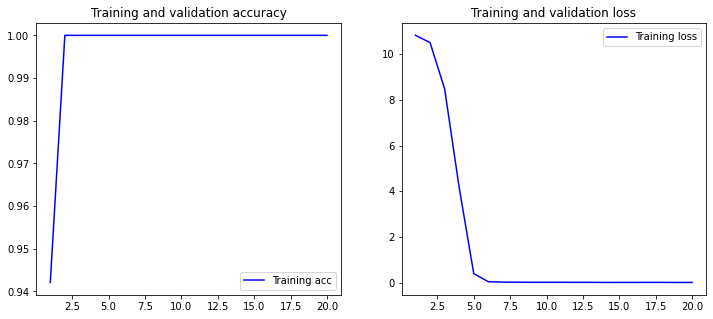

In [33]:
#Fit Model and plot Graph
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical


history = model.fit(X_padded,np.array(Y_padded) , validation_split= 0.25 ,verbose=1, batch_size = 100 , epochs=20 )



def plot_history(history):
    acc = history.history['accuracy']
   # val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
   # val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
  #  plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
 #   plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)

In [ ]:
plot_history(history)

KeyError: ignored

In [ ]:
#Evaluation of model
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report


from sklearn.preprocessing import MultiLabelBinarizer
#from sklearn.metrics import classification_report

tag2idx = dataGroup["Tag_Index"]
idx2tag = t

X_test = X_padded
test_pred = np.around(model.predict(X_padded))



classes = np.unique(idx2tag)
classes = classes.tolist()
new_classes = classes.pop()#remove the most common class


print(classification_report( y , test_pred))


In [ ]:

model.add(Embedding(input_dim=size-1, output_dim=output_dim, input_length=10))

